**Classifying Exoplanets: Exploring NASA's Kepler Space Observatory Dataset**

One of the most fascinating subjects in astronomical research is finding exoplanets, planets that orbit stars beyond our solar system. Examining exoplanets gives insight into planetary formation and evolution, critical information when searching for habitable planets.

The Kepler Space Observatory, a NASA space telescope for finding exoplanets, has analyzed thousands of planets, especially ones that are roughly Earth-sized and located within the habitable zones of their parent stars. From 2009 to 2018, Kepler revolutionized our understanding of extrasolar systems by cross-checking previous observations of exoplanets and labeling them as confirmed planets, candidates, or false positives.

Our primary question is: *Can we accurately classify celestial bodies as exoplanets based on their observed characteristics using the Kepler exoplanet dataset?*

Our project will analyze the NASA Kepler exoplanet dataset. This dataset contains details about celestial objects, including their radius, transit, stellar luminosity, and other essential attributes. By analyzing this dataset, we hope to develop a predictive model that discerns exoplanets from other extrasolar entities.

In [4]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [5]:
## Reading the data 
exoplanet <- read_csv("https://raw.githubusercontent.com/QuwackJ/dsci-100-group-37/main/Data/cumulative.csv")


## Selecting for our predictors
exoplanet_selected <- exoplanet |>
                        select(koi_disposition, koi_period, koi_depth, koi_duration, koi_impact)


head(exoplanet_selected)

## Splitting into training and testing data
exoplanet_split <- initial_split(exoplanet_selected, prop = 0.75, strata = koi_disposition)
training_data <- training(exoplanet_split)   
testing_data <- testing(exoplanet_split)

Rows: 9564 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): kepoi_name, kepler_name, koi_disposition, koi_pdisposition, koi_tc...
dbl (43): rowid, kepid, koi_score, koi_fpflag_nt, koi_fpflag_ss, koi_fpflag_...
lgl  (2): koi_teq_err1, koi_teq_err2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


koi_disposition koi_period koi_depth koi_duration koi_impact
1 CANDIDATE       47.1096306  752.2    5.7410       1.230     
2 FALSE POSITIVE   8.5898708   87.7    4.8060       0.765     
3 FALSE POSITIVE   0.5276985 1579.2    3.2221       1.252     
4 CANDIDATE        1.7398494   48.5    3.1140       0.043     
5 FALSE POSITIVE   0.6814016  103.6    0.8650       0.147     
6 FALSE POSITIVE   4.8560348   76.7    3.0780       0.134

Mean value of all predictors for the whole dataset


In [5]:
## Mean value of all predictors for the whole dataset
summary_table <- training_data |>
                    select(-koi_disposition) |>
                    map_df(mean, na.rm = TRUE)
summary_table

koi_period koi_depth koi_duration koi_impact
1 80.445     23356.05  5.641699     0.7256953

Mean value of all predictors for confirmed exoplanets

In [7]:
## Mean value of all predictors for confirmed exoplanets
summary_table_confirmed <- training_data |>
                    filter(koi_disposition == "CONFIRMED") |>
                    select(-koi_disposition) |>
                    map_df(mean, na.rm = TRUE)
summary_table_confirmed

koi_period koi_depth koi_duration koi_impact
1 26.95055   1140.939  4.309482     0.4208111

Mean value of all predictors for false positives that are not exoplanets

In [9]:
summary_table_false <- training_data |>
                    filter(koi_disposition == "FALSE POSITIVE") |>
                    select(-koi_disposition) |>
                    map_df(mean, na.rm = TRUE)
summary_table_false

koi_period koi_depth koi_duration koi_impact
1 73.64063   44131.4   6.607775     0.9504213

## Methods

Using NASA's Kepler exoplanet dataset, we aim to perform **K-nearest neighbor classification** and predict the most probable physical explanation of a KOI (Kepler Object of Interest). Since our objective is simply to classify whether a celestial body is an exoplanet or not, without delving into specifics about the planet type, we focus on the features that are most indicative of a planet's presence. In this context, the most crucial columns to include in our model to leverage the data most directly associated to exoplanets would be:

### Categorical variable:
 - **koi_disposition:** Category of a KOI from the Exoplanet Archive and using Kepler Data. A KOI can be classified into:
     - **Confirmed**: is an exoplanet
     - **False Positive**: failed one or more tests
     - **Candidate**: passed all prior tests but does not mean that all tests have been conducted
     
### Predictor variables:
 - **koi_period (Orbital period):** The presence of a consistent orbital period is one of the primary methods for detecting exoplanets, especially with the transit method.
 - **koi_depth (Transit depth):** The amount by which the star's brightness drops during a transit (indicative of a planet passing in front of the star). A significant, repeatable transit depth is a strong signal of an exoplanet.
 - **koi_duration (Transit Duration):** Gives information about the size and speed of the orbiting body. Together with orbital period and transit depth, it helps confirm the presence of a planet and rules out other phenomena like binary stars.
 - **koi_impact (Impact Parameter):** Sky-projected distance of the planet's path across the stellar disc. A feasible impact parameter, in conjunction with other transit characteristics, can help confirm the transit signals are due to a planet.

We have included a **bar graph** to compare the total counts of all dispositions of the exoplanets in the dataset used. \
We also have some **scatter plots** comparing the different predictors we are using against one another.

Table and bar graph showing counts of planet disposition types (ex: Confirmed, Candidate, False Positive)

koi_disposition count
1 CANDIDATE       2248 
2 CONFIRMED       2293 
3 FALSE POSITIVE  5023

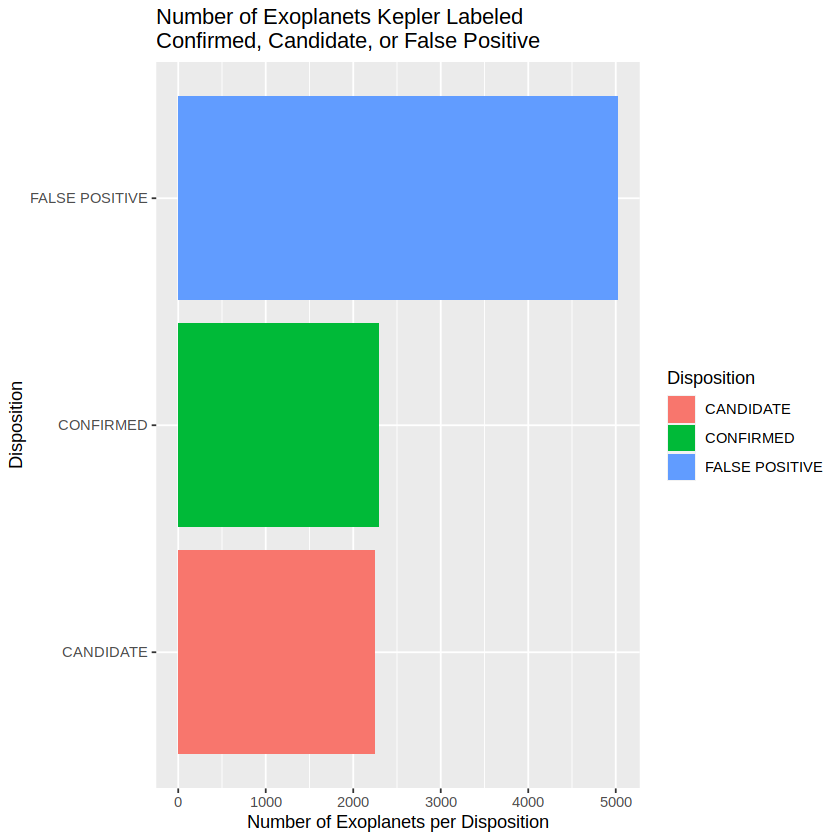

In [16]:
disposition_count <- exoplanet_selected |>
                     group_by(koi_disposition) |>
                     summarize(count = n())

disposition_count

disposition_count_plot <- disposition_count |>
                          ggplot(aes(x = count,
                                     y = fct_reorder(koi_disposition, count),
                                     fill = koi_disposition)) +
                          geom_bar(stat = "identity") +
                          labs(x = "Number of Exoplanets per Disposition", y = "Disposition", fill = "Disposition") +
                          ggtitle("Number of Exoplanets Kepler Labeled \nConfirmed, Candidate, or False Positive")

disposition_count_plot

Scatterplot showing relationship between koi_period (orbital period) and koi_depth (transit depth)

Warning message:
“Removed 363 rows containing missing values (`geom_point()`).”


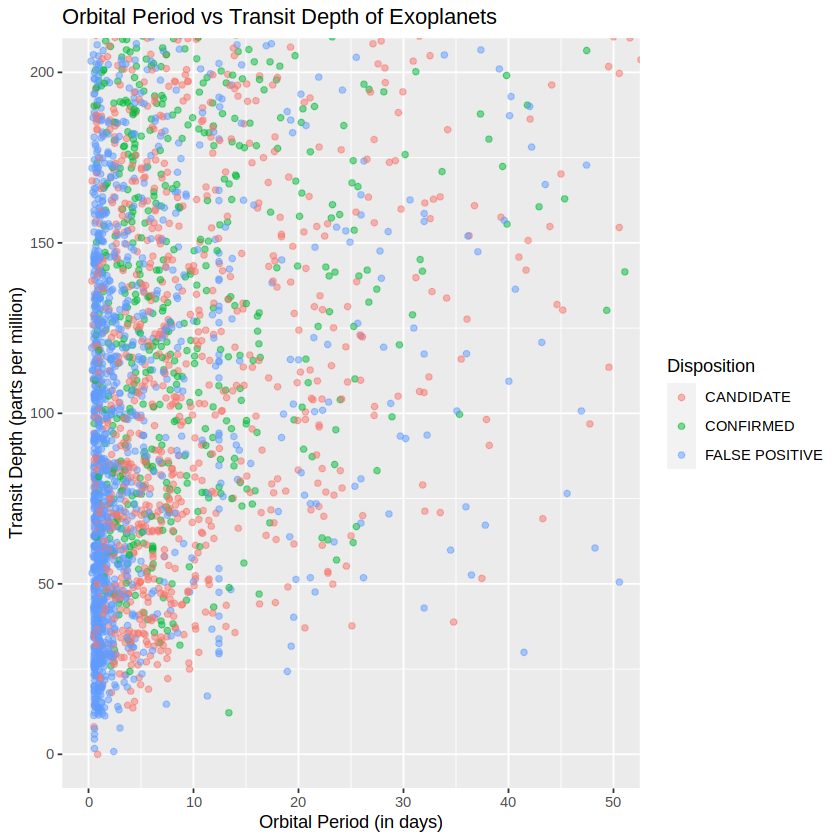

In [32]:
period_vs_depth <- exoplanet_selected |>
                   ggplot(aes(x = koi_period, y = koi_depth, color = koi_disposition)) +
                   geom_point(alpha = 0.5) +
                   coord_cartesian(xlim = c(0, 50), ylim = c(0, 200)) + 
                   labs(x = "Orbital Period (in days)", y = "Transit Depth (parts per million)", color = "Disposition") +
                   ggtitle("Orbital Period vs Transit Depth of Exoplanets")

period_vs_depth

Scatterplot showing relationship between koi_duration (transit duration) and koi_impact (impact parameter)

Warning message:
“Removed 363 rows containing missing values (`geom_point()`).”


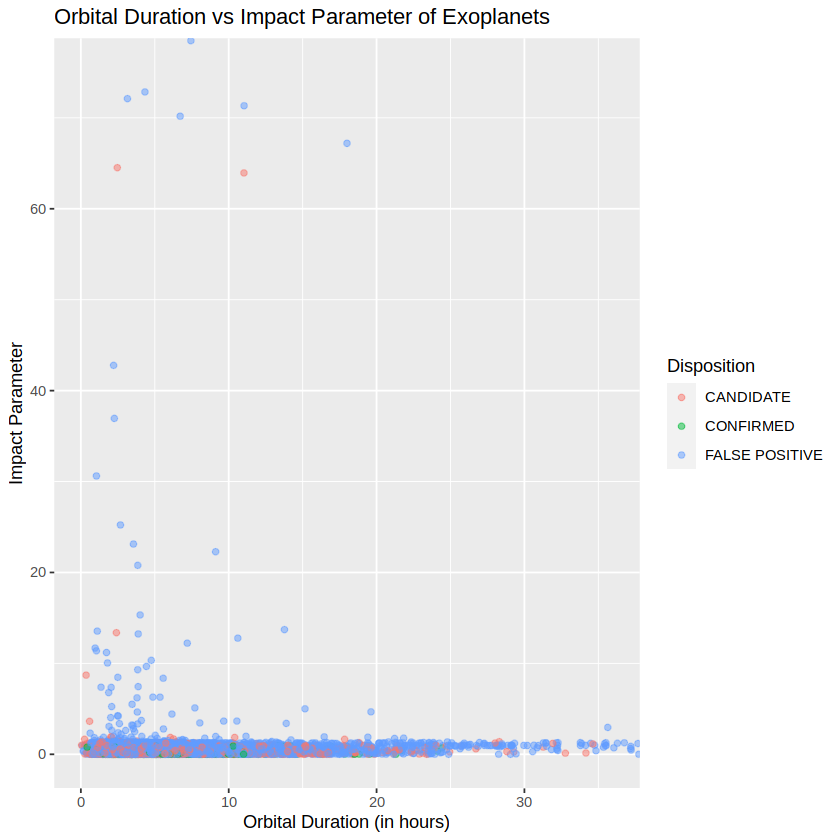

In [36]:
duration_vs_impact <- exoplanet_selected |>
                    ggplot(aes(x = koi_duration, y = koi_impact, color = koi_disposition)) +
                    geom_point(alpha = 0.5) +
                    coord_cartesian(xlim = c(0, 36), ylim = c(0, 75)) + 
                    labs(x = "Orbital Duration (in hours)", y = "Impact Parameter", color = "Disposition") +
                    ggtitle("Orbital Duration vs Impact Parameter of Exoplanets")

duration_vs_impact

Scatterplot showing relationship between koi_depth (transit depth) and koi_impact (impact parameter)

Warning message:
“Removed 363 rows containing missing values (`geom_point()`).”


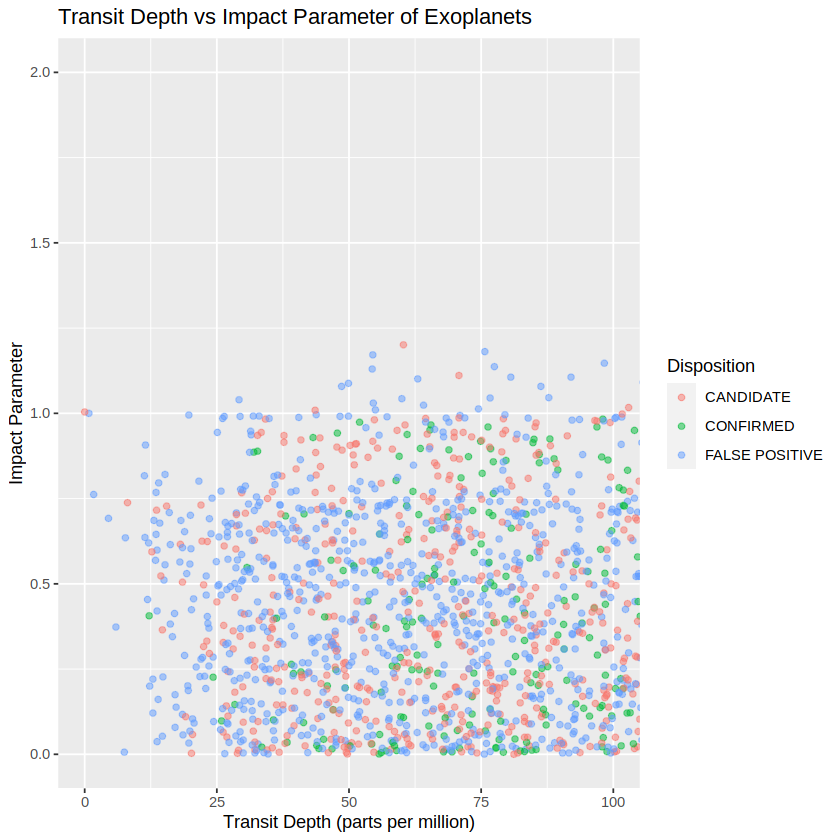

In [48]:
depth_vs_impact <- exoplanet_selected |>
                    ggplot(aes(x = koi_depth, y = koi_impact, color = koi_disposition)) +
                    geom_point(alpha = 0.5) +
                    # scale_x_continuous(trans = 'log10') +
                    # scale_y_continuous(trans = 'log10') +
                    coord_cartesian(xlim = c(0, 100), ylim = c(0, 2)) + 
                    labs(x = "Transit Depth (parts per million)", y = "Impact Parameter", color = "Disposition") +
                    ggtitle("Transit Depth vs Impact Parameter of Exoplanets")

depth_vs_impact